In [633]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import open3d as o3d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
import time
import moviepy.video.io.ImageSequenceClip
import copy
import networkx as nx
import math
sys.path.insert(0,'/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')

from Signal_processing_utils import dx_dt, get_activity_interval, bilateral_filter_smoothing
from Interpolation_Util import CubicSplineInterpolation, CatmullRomSplineInterpolation
from sklearn.linear_model import Ridge
from utils import *

In [634]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport Signal_processing_utils
%aimport Interpolation_Util
# %matplotlib widget
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
# input block
motion_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"
calibration_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"

# motion_data_path = "C:/Users/evan1/Documents/staggered_face/data/live_link_data/LiveLinkFace_20220926_MySlate_7_Evans_Iphone/MySlate_7_Evans_Iphone.csv"
mesh_to_name_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json"
name_to_mesh_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json"
out_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/for_maya_json.json"
model_path = "/Users/evanpan/Documents/GitHub/staggered_face/data/Apple blendshapes51 OBJs/OBJs"
mode = "acceleration"

# Inputs

In [302]:
kf_width = 2
aggregation_threshold = 3

In [305]:
times, values_dict = load_apple_motion(motion_data_path, 30, calibration_data_path)
all_AU = []
labels = list(values_dict.keys())
for i in range(0, len(labels)):
    all_AU.append(labels[i])
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, calibration_data_path)
# play_animation(animation, save_video=True)
ARkit_2_blendshapeModel_map = {'eyeblink_r': 'eyeblinkright', 'eyelookdown_r': 'eyelookdownright', 'eyelookin_r': 'eyelookinright', 'eyelookout_r': 'eyelookoutright', 'eyelookup_r': 'eyelookupright', 'eyesquint_r': 'eyesquintright', 'eyewide_r': 'eyewideright', 'eyeblink_l': 'eyeblinkleft', 'eyelookdown_l': 'eyelookdownleft', 'eyelookin_l': 'eyelookinleft', 'eyelookout_l': 'eyelookoutleft', 'eyelookup_l': 'eyelookupleft', 'eyesquint_l': 'eyesquintleft', 'eyewide_l': 'eyewideleft', 'jawforward': 'jawforward', 'jawright': 'jawright', 'jawleft': 'jawleft', 'jawopen': 'jawopen', 'mouthclose': 'mouthclose', 'mouthfunnel': 'mouthfunnel', 'mouthpucker': 'mouthpucker', 'mouthright': 'mouthright', 'mouthleft': 'mouthleft', 'mouthsmile_r': 'mouthsmileright', 'mouthsmile_l': 'mouthsmileleft', 'mouthfrown_r': 'mouthfrownright', 'mouthfrown_l': 'mouthfrownleft', 'mouthdimple_r': 'mouthdimpleright', 'mouthdimple_l': 'mouthdimpleleft', 'mouthstretch_r': 'mouthstretchright', 'mouthstretch_l': 'mouthstretchleft', 'mouthrolllower': 'mouthrolllower', 'mouthrollupper': 'mouthrollupper', 'mouthshruglower': 'mouthshruglower', 'mouthshrugupper': 'mouthshrugupper', 'mouthpress_r': 'mouthpressright', 'mouthpress_l': 'mouthpressleft', 'mouthlowerdown_r': 'mouthlowerdownright', 'mouthlowerdown_l': 'mouthlowerdownleft', 'mouthupperup_r': 'mouthupperupright', 'mouthupperup_l': 'mouthupperupleft', 'browdown_r': 'browdownright', 'browdown_l': 'browdownleft', 'browinnerup': 'browinnerup', 'browouterup_r': 'browouterupright', 'browouterup_l': 'browouterupleft', 'cheekpuff': 'cheekpuff', 'cheeksquint_r': 'cheeksquintright', 'cheeksquint_l': 'cheeksquintleft', 'nosesneer_r': 'nosesneerright', 'nosesneer_l': 'nosesneerleft'}

In [727]:
onset_threshold = 0.05
offset_threshold = 0.05
noise_threshold = 0.2
curve_index = 0
onset_curve_dict = {}
offset_curve_dict = {}
labeled_key_frame_dict = {}
for i in range(curve_index, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    filtered_au_i_curve = au_i_curve
    # find onset
    au_i_vel_curve_forward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=1)
    au_i_vel_curve_backward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=3)
    onsets = np.zeros(au_i_vel_curve_forward.shape)
    offsets = np.zeros(au_i_vel_curve_forward.shape)
    ts = list(range(0, au_i_vel_curve_forward.shape[0]))
    for t in ts:
        # if the AU is increasing sufficiently we set the element in the onsets array it to 1
        # here we use backward differences to capture the onset t[i+1] - t[i]
        if au_i_vel_curve_backward[t] >= onset_threshold or au_i_vel_curve_forward[t] >= onset_threshold: 
            onsets[t] = 1
        # if the AU is decreasing sufficiently we set the element in the offsets array it to 1
        # here we use backward difference 
        if au_i_vel_curve_forward[t] <= -offset_threshold or au_i_vel_curve_backward[t] <= -offset_threshold:
            offsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_onset_activity = get_activity_interval(onsets, np.array(ts))
    action_unit_offset_activity = get_activity_interval(offsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    offset_curve_dict[au_i] = offsets
    # activation, peak, sustain and deactivation values
    activation = [x[0] for x in action_unit_onset_activity]
    peak = [x[1] for x in action_unit_onset_activity]
    sustain = [x[0] for x in action_unit_offset_activity]
    deactivation = [x[1] for x in action_unit_offset_activity]
    # plot all the key points
    labeled_key_frames = []
    for pts in activation:
        labeled_key_frames.append([pts, "a"])
    for pts in peak:
        labeled_key_frames.append([pts, "p"])
    for pts in sustain:
        labeled_key_frames.append([pts, "s"])
    for pts in deactivation:
        labeled_key_frames.append([pts, "d"])
    # sort all the potential key frames by time
    if len(labeled_key_frames) == 0:
        labeled_key_frames = [[0, "a"], [len(ts)-1, "d"]]
    labeled_key_frames = sorted(labeled_key_frames, key=lambda x: x[0])
    filtered_labeled_kay_frames = []
    ff = 0
    while ff < len(labeled_key_frames) - 1:
        current = labeled_key_frames[ff]
        next = labeled_key_frames[ff+1]
        if current[0] != next[0]:
            filtered_labeled_kay_frames.append(current)
        # elif (current[1] == "a" and next[1] == "p") or (current[1] == "s" and next[1] == "d"):
        elif (current[1] == "a" and next[1] == "d") or (current[1] == "d" and next[1] == "a"):
            filtered_labeled_kay_frames.append([current[0], "d"])
            # filtered_labeled_kay_frames.append([current[0], "a"])
            ff += 1
        elif au_i_curve[current[0]] <= noise_threshold:
            filtered_labeled_kay_frames.append([current[0], "z"])
            # filtered_labeled_kay_frames.append([current[0], "z"])
            ff += 1
        ff += 1
    # add the last frame (which is probably missing )
    filtered_labeled_kay_frames.append(labeled_key_frames[-1])
    # replace the keyframed with the filtered version
    labeled_key_frames = copy.deepcopy(filtered_labeled_kay_frames)
    # save the keyframe
    labeled_key_frame_dict[au_i] = labeled_key_frames
    plotting_key_frames = [x[0] for x in labeled_key_frames]
    approximation = CatmullRomSplineInterpolation(np.array(ts)[plotting_key_frames], filtered_au_i_curve[plotting_key_frames], tao=0.2)
    # plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="catmull rom")

In [728]:
times = np.array(times)
kf_times_dict = {}
kf_times_aggregate = np.zeros(times.shape)
for key in labeled_key_frame_dict:
    kf_indices = labeled_key_frame_dict[key]
    kf_indices = [x[0] for x in kf_indices]
    kf_indices = [kf_indices[i] for i in range(len(kf_indices)) if i == 0 or kf_indices[i] != kf_indices[i-1]]
    kf_times = np.zeros(times.shape)
    for t in range(0, len(kf_indices)):
        kf_times[kf_indices[t]] = 1
    kf_times = gaussian_filter1d(kf_times, kf_width) 
    kf_times_aggregate += kf_times
    kf_times_dict[key] = kf_times

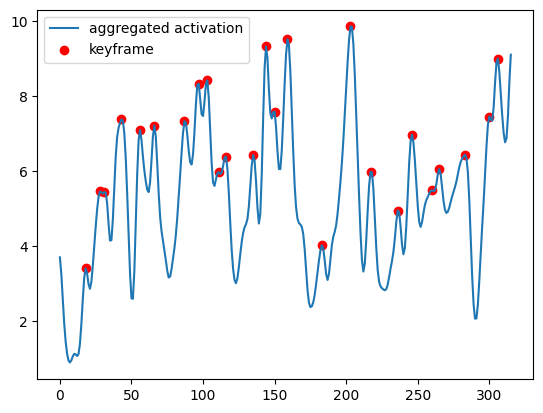

In [729]:
from scipy.signal import argrelextrema

# for local extremes on the aggregated curve
extremes = argrelextrema(kf_times_aggregate, np.greater)[0]
extremes_filtered = []
for i in range(0, len(extremes)):
    if kf_times_aggregate[extremes[i]] >= aggregation_threshold:
        extremes_filtered.append(extremes[i])
# gather a list of superframes
superframes:list[SuperFrame] = []
for i in range(0, len(extremes_filtered)):
    # time of a global keyframe
    kf_time = extremes_filtered[i]
    # add all the keyframes within a certain distance from these key points
    groupings = []
    for key in kf_times_dict:
        for isolated_kf_time in labeled_key_frame_dict[key]:
            if abs(isolated_kf_time[0] - kf_time) <= kf_width:
                groupings.append([key, isolated_kf_time[0]])
    superframes.append(SuperFrame(groupings))
plt.clf()
plt.plot(kf_times_aggregate, label="aggregated activation")
plt.scatter(extremes_filtered, kf_times_aggregate[extremes_filtered], c="r", label="keyframe")
plt.legend()
plt.show()


# Play with spline based method

In [730]:
labeled_key_frame_dict      # isolated keyframes for each attribute (indices)
extremes_filtered           # aggregated keyframe for each attribute (indices)
values_dict                 # the values for each frame
times                       # time for each frames
superframes                 # a list of superframe objects

# weight names in fixed order
blendshape_names = list(values_dict.keys())
blendshape_names.sort()

# The following are generated from the raw input above 
# both of these will have time as the x variable
all_delta_maps: dict[str: CatmullRomSplineInterpolation] = {}
all_splines: dict[str: CatmullRomSplineInterpolation] = {}


## generate the necessary data structure

In [731]:
# construct the necessary data structure for each weight
for b_name in blendshape_names:
    values_i = values_dict[b_name]
    times_i = times 
    # get the keyframe time and values. 
    labeled_kf_i = labeled_key_frame_dict[b_name]
    kf_x = []
    kf_y = []
    # store the time and values into kf_x and kf_y respectiveky
    for k in range(0, len(labeled_kf_i)):
        kf_x.append(times_i[labeled_kf_i[k][0]])
        kf_y.append(values_i[labeled_kf_i[k][0]])
    spline = CatmullRomSplineInterpolation(kf_x, kf_y, lower_bound=0)
    all_splines[b_name] = spline
    # get the delta map
    approx = spline.eval(times_i)
    deltas_i = values_i - approx
    delta_map = CatmullRomSplineInterpolation(times, deltas_i)
    all_delta_maps[b_name] =delta_map

## Do value transformation

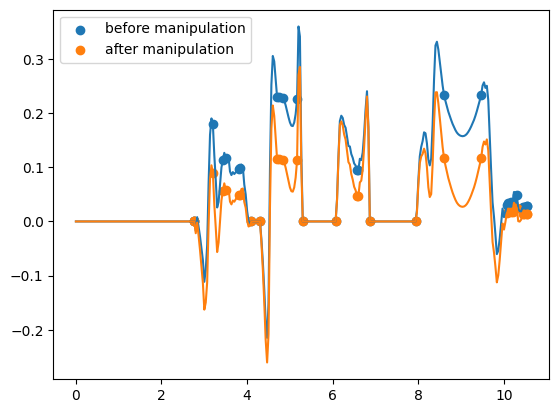

In [809]:
def change_value(spline_maps, b_name, index, new_value):
    spline: CatmullRomSplineInterpolation = spline_maps[b_name]
    spline.y[index] = new_value
    spline_maps[b_name] = spline
    return spline_maps
for b_name in blendshape_names:
    spline = all_splines[b_name]
    plt.plot(times, spline.eval(times) + all_delta_maps[b_name].eval(times))
    plt.scatter(spline.x, spline.y + all_delta_maps[b_name].eval(spline.x), label="before manipulation")
    for i in range(spline.x.shape[0]):
        all_splines = change_value(all_splines, b_name, i, np.minimum(1, spline.y[i] * 0.5))
    plt.plot(times, all_splines[b_name].eval(times) + all_delta_maps[b_name].eval(times))
    plt.scatter(spline.x, spline.y + all_delta_maps[b_name].eval(spline.x), label="after manipulation")
    plt.legend()
    plt.show()
    break

# Play with skinning-inspired method (I should have done the math! Fuck!)

In [733]:
labeled_key_frame_dict      # isolated keyframes for each attribute (indices)
extremes_filtered           # aggregated keyframe for each attribute (indices)
values_dict                 # the values for each frame
times                       # time for each frames
superframes                 # a list of superframe objects

# weight names in fixed order
blendshape_names = list(values_dict.keys())
blendshape_names.sort()

In [734]:
controllable_curves_dict = {}
for key in blendshape_names:
    kfs = labeled_key_frame_dict[key]
    kfs_indices = [x[0] for x in kfs]
    controllable_curves_dict[key] = [copy.deepcopy(times), copy.deepcopy(values_dict[key]), copy.deepcopy(times[kfs_indices]), copy.deepcopy(values_dict[key][kfs_indices])]

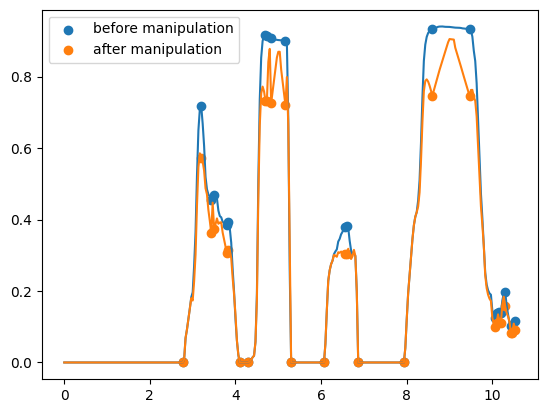

In [735]:
def change_value_weighted_skinning(controllable_curves_dict, b_name, ctpt_index, new_value, fps=30, influence=[1.0, 1.0]):
    # get the control_points and the inputs
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    
    # work with the left half of the window:
    prev_index = np.maximum(ctpt_index - 1, 0)
    left_time = ctpt_t[prev_index]
    curr_time = ctpt_t[ctpt_index]
    left_time = curr_time - (curr_time - left_time) * 0.55
    curr_time_index = -1
    if prev_index != ctpt_index and left_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= left_time:
                in_win_index.append(i)
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] == curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        # index of all points in the window
        l_window = np.arange(in_win_index[0], in_win_index[1]+1)
        # compute weights of influence on those points depend on distance in time
        ts = t[l_window]
        weights = (curr_time - ts)/(curr_time - left_time)
        weights = 1 - weights
        # add the difference
        delta_t = new_value[0] - ctpt_t[ctpt_index]
        delta_y = new_value[1] - ctpt_y[ctpt_index]
        t[l_window] += delta_t * weights
        y[l_window] += delta_y * weights
    # right side of the window
    next_index = np.minimum(ctpt_index + 1, ctpt_t.shape[0]-1)
    right_time = ctpt_t[next_index]
    right_time = curr_time + (right_time - curr_time) * 0.55
    if next_index != ctpt_index and right_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] == curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] >= right_time:
                in_win_index.append(i)
                break
        # index of all points in the window
        r_window = np.arange(in_win_index[0], in_win_index[1]+1)
        # compute weights of influence on those points depend on distance in time
        ts = t[r_window]
        weights = (ts - curr_time)/(right_time - curr_time)
        weights = 1 - weights
        # add the difference
        delta_t = new_value[0] - ctpt_t[ctpt_index]
        delta_y = new_value[1] - ctpt_y[ctpt_index]
        t[r_window] += delta_t * weights
        y[r_window] += delta_y * weights
    ctpt_t[ctpt_index] = new_value[0]
    ctpt_y[ctpt_index] = new_value[1]
    t[curr_time_index] = new_value[0]
    y[curr_time_index] = new_value[1]
    controllable_curves_dict[b_name] = [t, y, ctpt_t, ctpt_y]
    return controllable_curves_dict
for b_name in blendshape_names:
    t, y, ctpt_t, ctpy_y = controllable_curves_dict[b_name]
    plt.plot(t, y)
    plt.scatter(ctpt_t, ctpy_y, label="before manipulation")
    for i in range(ctpt_t.shape[0]):
        controllable_curves_dict = change_value_weighted_skinning(controllable_curves_dict, b_name, i, [ctpt_t[i], ctpy_y[i] * 0.8])
    plt.plot(controllable_curves_dict[b_name][0], controllable_curves_dict[b_name][1])
    plt.scatter(controllable_curves_dict[b_name][2], controllable_curves_dict[b_name][3], label="after manipulation")
    plt.legend()
    plt.show()
    break

In [720]:
controllable_curves_dict = {}
for key in blendshape_names:
    kfs = labeled_key_frame_dict[key]
    kfs_indices = [x[0] for x in kfs]
    controllable_curves_dict[key] = [copy.deepcopy(times), copy.deepcopy(values_dict[key]), copy.deepcopy(times[kfs_indices]), copy.deepcopy(values_dict[key][kfs_indices])]

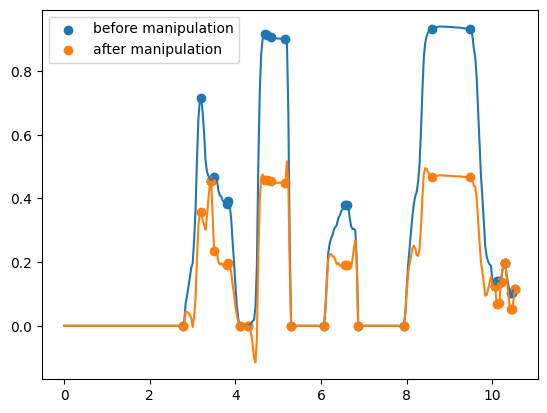

In [721]:
def change_value_spline_deltas(controllable_curves_dict, b_name, ctpt_index, new_value):
    # get the control_points and the inputs
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    spline_old = CatmullRomSplineInterpolation(copy.deepcopy(ctpt_t), copy.deepcopy(ctpt_y), .01)
    spline_new = CatmullRomSplineInterpolation(copy.deepcopy(ctpt_t), copy.deepcopy(ctpt_y), .01)
    spline_new.x[ctpt_index+1] = new_value[0]
    spline_new.y[ctpt_index+1] = new_value[1]
    # get a range for the window
    prev_index = np.maximum(ctpt_index - 1, 0)
    left_time = ctpt_t[prev_index]
    curr_time = ctpt_t[ctpt_index]
    left_time = curr_time - (curr_time - left_time)
    next_index = np.minimum(ctpt_index + 1, ctpt_t.shape[0]-1)
    right_time = ctpt_t[next_index]
    right_time = curr_time + (right_time - curr_time)
    curr_time_index = -1
    new_t_l, new_t_r = [], []
    l_window, r_window = [], []

    # if the new time is weird, do not proceed
    if new_value[0] >= right_time or new_value[0] <= left_time:
        return controllable_curves_dict
    
    # work with the left half of the window:
    if prev_index != ctpt_index and left_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= left_time:
                in_win_index.append(i)
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] == curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        # index of all points in the window
        l_window = np.arange(in_win_index[0], in_win_index[1])
        # scale time
        factor = (new_value[0] - left_time) / (curr_time - left_time)
        new_t_l = (t[l_window] - left_time) * factor + left_time
        # compute weights of influence on those points depend on distance in time
        delta_y = spline_new.eval(new_t_l) - spline_old.eval(new_t_l)
        # add the difference to update value
        y[l_window] += delta_y
        
    # right side of the window
    if next_index != ctpt_index and right_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] >= right_time:
                in_win_index.append(i)
                break
        # index of all points in the window
        r_window = np.arange(in_win_index[0], in_win_index[1])
        # scale time
        factor = (right_time - new_value[0]) / (right_time - curr_time)
        new_t_r = (t[r_window] - curr_time) * factor + curr_time
        # compute weights of influence on those points depend on distance in time
        delta_y = spline_new.eval(new_t_r) - spline_old.eval(new_t_r)
        y[r_window] += delta_y
    # t[curr_time_index] = new_value[0]
    if len(l_window) > 0: t[l_window] = new_t_l
    if len(r_window) > 0: t[r_window] = new_t_r
    y[curr_time_index] = new_value[1]
    t[curr_time_index] = new_value[0]
    ctpt_t[ctpt_index] = new_value[0]
    ctpt_y[ctpt_index] = new_value[1]
    controllable_curves_dict[b_name] = [t, y, ctpt_t, ctpt_y]
    return controllable_curves_dict

for b_name in blendshape_names:
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    plt.plot(t, y)
    plt.scatter(ctpt_t, ctpt_y, label="before manipulation")
    for i in range(ctpt_t.shape[0]):
        controllable_curves_dict = change_value_spline_deltas(controllable_curves_dict, b_name, i, [ctpt_t[i], ctpt_y[i] * 0.5])
    plt.plot(controllable_curves_dict[b_name][0], controllable_curves_dict[b_name][1])
    plt.scatter(controllable_curves_dict[b_name][2], controllable_curves_dict[b_name][3], label="after manipulation")
    plt.legend()
    plt.show()
    break

In [659]:
controllable_curves_dict = {}
for key in blendshape_names:
    kfs = labeled_key_frame_dict[key]
    kfs_indices = [x[0] for x in kfs]
    controllable_curves_dict[key] = [copy.deepcopy(times), copy.deepcopy(values_dict[key]), copy.deepcopy(times[kfs_indices]), copy.deepcopy(values_dict[key][kfs_indices])]

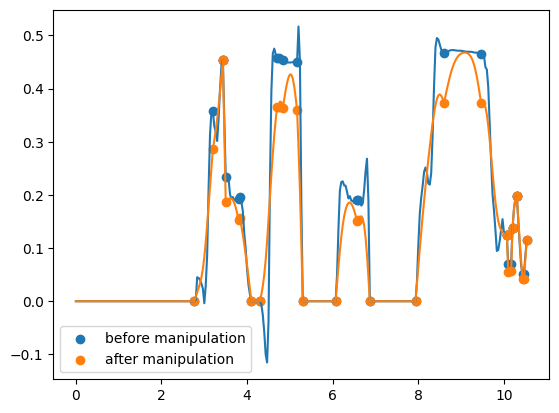

In [722]:
def change_value_laplacian_smoothing(controllable_curves_dict, b_name, ctpt_index, new_value, iterations=1):
    # get the control_points and the inputs
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    # get a range for the window
    prev_index = np.maximum(ctpt_index - 1, 0)
    left_time = ctpt_t[prev_index]
    curr_time = ctpt_t[ctpt_index]
    left_time = curr_time - (curr_time - left_time)
    next_index = np.minimum(ctpt_index + 1, ctpt_t.shape[0]-1)
    right_time = ctpt_t[next_index]
    right_time = curr_time + (right_time - curr_time)
    curr_time_index = -1
    new_t_l, new_t_r = [], []
    l_window, r_window = [], []
    # if the new time is weird, do not proceed
    if new_value[0] >= right_time or new_value[0] <= left_time:
        return controllable_curves_dict
    
    # work with the left half of the window:
    if prev_index != ctpt_index and left_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= left_time:
                in_win_index.append(i)
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] == curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        # index of all points in the window
        l_window = np.arange(in_win_index[0], in_win_index[1]+1)
        # smooth the window using laplacian filtering
        y_vals = y[l_window]
        t_vals = t[l_window]
        t_vals[-1] = new_value[0]
        y_vals[-1] = new_value[1]
        y_vals = laplacian_smoothing(y_vals, l_window.shape[0] * iterations)
        t_vals = laplacian_smoothing(t_vals, l_window.shape[0] * iterations)
        y[l_window] = y_vals
        t[l_window] = t_vals
    # right side of the window
    if next_index != ctpt_index and right_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] >= right_time:
                in_win_index.append(i)
                break
        # index of all points in the window
        r_window = np.arange(in_win_index[0], in_win_index[1]+1)
        # smooth the window using laplacian filtering
        y_vals = y[r_window]
        t_vals = t[r_window]
        t_vals[0] = new_value[0]
        y_vals[0] = new_value[1]
        y_vals = laplacian_smoothing(y_vals, r_window.shape[0] * iterations)
        t_vals = laplacian_smoothing(t_vals, r_window.shape[0] * iterations)
        y[r_window] = y_vals
        t[r_window] = t_vals
    # t[curr_time_index] = new_value[0]
    ctpt_t[ctpt_index] = new_value[0]
    ctpt_y[ctpt_index] = new_value[1]
    controllable_curves_dict[b_name] = [t, y, ctpt_t, ctpt_y]
    return controllable_curves_dict

for b_name in blendshape_names:
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    plt.plot(t, y)
    plt.scatter(ctpt_t, ctpt_y, label="before manipulation")
    for i in range(ctpt_t.shape[0]):
        controllable_curves_dict = change_value_laplacian_smoothing(controllable_curves_dict, b_name, i, [ctpt_t[i], ctpt_y[i] * 0.8])
    plt.plot(controllable_curves_dict[b_name][0], controllable_curves_dict[b_name][1])
    plt.scatter(controllable_curves_dict[b_name][2], controllable_curves_dict[b_name][3], label="after manipulation")
    plt.legend()
    plt.show()
    break

In [836]:
controllable_curves_dict = {}
for key in blendshape_names:
    kfs = labeled_key_frame_dict[key]
    kfs_indices = [x[0] for x in kfs]
    controllable_curves_dict[key] = [copy.deepcopy(times), copy.deepcopy(values_dict[key]), copy.deepcopy(times[kfs_indices]), copy.deepcopy(values_dict[key][kfs_indices])]


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11594/2994329164.py:51: RuntimeWarning: invalid value encountered in double_scalars
  r_ratio = (new_value[1] - ctpt_y[next_index])/(ctpt_y[ctpt_index] - ctpt_y[next_index])
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11594/2994329164.py:32: RuntimeWarning: invalid value encountered in double_scalars
  l_ratio = (new_value[1] - ctpt_y[prev_index])/(ctpt_y[ctpt_index] - ctpt_y[prev_index])


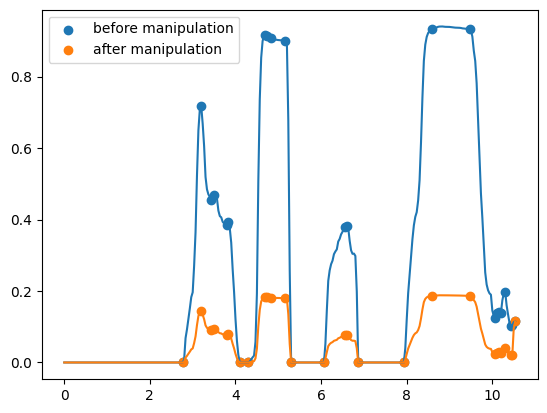

In [841]:
def change_value_multiplicative(controllable_curves_dict, b_name, ctpt_index, new_value, iterations=1):
    # get the control_points and the inputs
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    # get a range for the window
    prev_index = np.maximum(ctpt_index - 1, 0)
    left_time = ctpt_t[prev_index]
    curr_time = ctpt_t[ctpt_index]
    left_time = curr_time - (curr_time - left_time)
    next_index = np.minimum(ctpt_index + 1, ctpt_t.shape[0]-1)
    right_time = ctpt_t[next_index]
    right_time = curr_time + (right_time - curr_time)
    l_window, r_window = [], []
    # if the new time is weird, do not proceed
    if new_value[0] >= right_time or new_value[0] <= left_time:
        return controllable_curves_dict
    curr_time_index = -1
    # work with the left half of the window:
    if prev_index != ctpt_index and left_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= left_time:
                in_win_index.append(i)
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] == curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        # index of all points in the window
        l_window = np.arange(in_win_index[0], in_win_index[1]+1)
        l_ratio = (new_value[1] - ctpt_y[prev_index])/(ctpt_y[ctpt_index] - ctpt_y[prev_index])
        if ctpt_y[ctpt_index] - ctpt_y[prev_index] == 0:
            l_ratio = 0
        y[l_window] = (y[l_window] - ctpt_y[prev_index]) * l_ratio + ctpt_y[prev_index]
    # right side of the window
    if next_index != ctpt_index and right_time != curr_time: # only change the curve value if it's needed
        # find all points inside this window
        in_win_index = []
        for i in range(0, t.shape[0]):
            if t[i] >= curr_time:
                in_win_index.append(i)
                curr_time_index = i
                break
        for i in range(in_win_index[-1], t.shape[0]):
            if t[i] >= right_time:
                in_win_index.append(i)
                break
        # index of all points in the window
        r_window = np.arange(in_win_index[0], in_win_index[1]+1)
        r_ratio = (new_value[1] - ctpt_y[next_index])/(ctpt_y[ctpt_index] - ctpt_y[next_index])
        if ctpt_y[ctpt_index] - ctpt_y[next_index] == 0:
            r_ratio = 0
        y[r_window] = (y[r_window] - ctpt_y[next_index]) * r_ratio + ctpt_y[next_index]
    ctpt_t[ctpt_index] = new_value[0]
    ctpt_y[ctpt_index] = new_value[1]
    if curr_time_index >= 0:
        y[curr_time_index] = new_value[1]
    controllable_curves_dict[b_name] = [t, y, ctpt_t, ctpt_y]
    return controllable_curves_dict
for b_name in blendshape_names:
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    plt.plot(t, y)
    plt.scatter(ctpt_t, ctpt_y, label="before manipulation")
    for i in range(ctpt_t.shape[0]):
        controllable_curves_dict = change_value_multiplicative(controllable_curves_dict, b_name, i, [ctpt_t[i], ctpt_y[i] * 0.2])
    plt.plot(controllable_curves_dict[b_name][0], controllable_curves_dict[b_name][1])
    plt.scatter(controllable_curves_dict[b_name][2], controllable_curves_dict[b_name][3], label="after manipulation")
    plt.legend()
    plt.show()
    break

In [1509]:
controllable_curves_dict = {}
for key in blendshape_names:
    kfs = labeled_key_frame_dict[key]
    kfs_indices = [x[0] for x in kfs]
    controllable_curves_dict[key] = [copy.deepcopy(times), copy.deepcopy(values_dict[key]), copy.deepcopy(times[kfs_indices]), copy.deepcopy(values_dict[key][kfs_indices])]


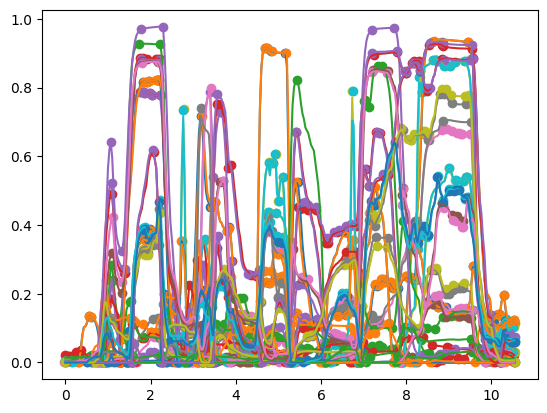

In [1531]:
from scipy.interpolate import interp1d
class MarlarkiRelativeTimeInterpolation:
    def __init__(self, x, y, ctpt_x, ctpt_y, tao=0.5, lower_bound=None):
        # these will be unchanging
        self.x = np.array(copy.deepcopy(x))
        self.y = np.array(copy.deepcopy(y))
        # these are the interp functions 
        self.curves_list: list[interp1d] = []
        self.extra_start = 0 # see if there is an additional keyframe added at frame 0
        self.extra_end = 0 # see if there is an additional keyframe added at the final frame
        # this can be used 
        self.range_list = [] # this contains inclusive range, such that if range is [1, 2] the interval contains points with index 1 and 2
        # this will be modifier for range
        self.range_delta_list = []
        
        # the control points
        self.ctpt_x = copy.deepcopy(ctpt_x) # time is never directly changed
        self.ctpt_x_delta = [] 
        self.ctpt_y = copy.deepcopy(ctpt_y) # values are manipulated
        
        # if the very first frame is not a keyframe, we add one 
        if self.ctpt_x[0] != self.x[0]: 
            start_index = 0
            end_index = self.__binary_search(self.ctpt_x[0])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
            self.extra_start = 1
        # start on the second frame if 
        for i in range(0, self.ctpt_x.shape[0] - 1):
            start_index = self.__binary_search(self.ctpt_x[i])
            end_index = self.__binary_search(self.ctpt_x[i+1])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
        if self.ctpt_x[-1] != self.x[-1]: 
            start_index = self.__binary_search(self.ctpt_x[-1])
            end_index = self.__binary_search(self.x[-1])
            x_prime = ((self.x[start_index:end_index+1]) - self.x[start_index]) / (self.x[end_index] - self.x[start_index])
            self.curves_list.append(interp1d(x_prime, self.y[start_index:end_index+1], bounds_error=False))
            self.range_list.append([start_index, end_index])
            self.extra_end = 1
        for i in range(0, len(self.range_list)):
            self.range_delta_list.append([0, 0])
        for i in range(0, self.ctpt_x.shape[0]):
            self.ctpt_x_delta.append(0)
    def __binary_search(self, t):
        if t <= self.x[0]:
            return 0
        elif t > self.x[-1]:
            return self.x.shape[0]-1
        # find it
        left, right = 0, self.x.shape[0] - 1
        index = -1
        while left <= right:
            mid = (left + right) // 2
            
            if self.x[mid] < t:
                index = mid
                left = mid + 1
            else:
                right = mid - 1
        return index+1
    def __find_range(self, t):
        for i in range(0, len(self.range_list)):
            if t >= self.x[self.range_list[i][0]] + self.range_delta_list[i][0] and t <= self.x[self.range_list[i][1]] + self.range_delta_list[i][1]:
                return i
        return -1
    def eval_single(self, x):
        # here we ensure that we will never get to the end of the curve
        if x <= self.x[0]:
            return self.y[0]
        elif x >= self.x[-1]:
            return self.y[-1]
        # find the range that contains both x
        curve_id = self.__find_range(x)
        # get the range (i.e. the two keyframes)
        curve_range = self.range_list[curve_id]
        curve_delta = self.range_delta_list[curve_id]
        # get the normalized time value
        x_prime = (x - self.x[curve_range[0]]-curve_delta[0]) / (self.x[curve_range[1]] + curve_delta[1] - self.x[curve_range[0]] - curve_delta[0])
        # evaluate the value:
        curve = self.curves_list[curve_id]
        return curve(x_prime)
    def eval(self, ts):
        out = np.zeros(ts.shape)
        for i in range(0, ts.shape[0]):
            out[i] = self.eval_single(ts[i])
        return out
    def update_y(self, ctpt_id, new_val):
        # i.e. the n-the control point correcsponds to the n-th range with the ctpt on the left
        curve_id = ctpt_id + self.extra_start 
        old_val = self.ctpt_y[ctpt_id]
        if curve_id-1 >= 0:
            curve_range_km1 = self.range_list[curve_id-1]
            # this is inclusive range
            l_ratio = (new_val - self.y[curve_range_km1[0]])/(old_val - self.y[curve_range_km1[0]])
            if self.y[curve_range_km1[1]] - self.y[curve_range_km1[0]] == 0:
                l_ratio = 0
            if abs(l_ratio) > 100:
                l_ratio = (new_val)/(old_val)
            self.y[curve_range_km1[0]:curve_range_km1[1]+1] = (self.y[curve_range_km1[0]:curve_range_km1[1]+1] - self.y[curve_range_km1[0]]) * l_ratio + self.y[curve_range_km1[0]]
            self.curves_list[curve_id-1] = (interp1d(self.curves_list[curve_id-1].x, self.y[curve_range_km1[0]:curve_range_km1[1]+1], bounds_error=False))  
            self.y[curve_range_km1[1]] = new_val 
        if curve_id < len(self.range_list):
            curve_range_kp1 = self.range_list[curve_id]
            self.y[curve_range_kp1[0]] = old_val
            r_ratio = (new_val - self.y[curve_range_kp1[1]])/(old_val - self.y[curve_range_kp1[1]])
            if self.y[curve_range_kp1[0]] - self.y[curve_range_kp1[1]] == 0:
                r_ratio = 0
            if abs(r_ratio) > 100:
                r_ratio = (new_val)/(old_val)
            self.y[curve_range_kp1[0]:curve_range_kp1[1]+1] = (self.y[curve_range_kp1[0]:curve_range_kp1[1]+1] - self.y[curve_range_kp1[1]]) * r_ratio + self.y[curve_range_kp1[1]]
            self.curves_list[curve_id] = interp1d(self.curves_list[curve_id].x, self.y[curve_range_kp1[0]:curve_range_kp1[1]+1], bounds_error=False)
            self.y[curve_range_kp1[0]] = new_val 
        self.ctpt_y[ctpt_id] = new_val 
    def update_x(self, ctpt_id, new_delta):
        # update the control point delta
        self.ctpt_x_delta[ctpt_id] = new_delta
        # do the same to the intervals
        right_interval_id = ctpt_id + self.extra_start
        # update the delta in control point
        if right_interval_id < len(self.range_delta_list):
            self.range_delta_list[right_interval_id][0] = new_delta
        if right_interval_id - 1 > 0:
            self.range_delta_list[right_interval_id-1][1] = new_delta
    def get_ctpt_xs(self):
        rtv = np.zeros(self.ctpt_x.shape)
        for i in range(0, len(self.ctpt_x)):
            rtv[i] = self.ctpt_x_delta[i] + self.ctpt_x[i]
        return rtv
for b_name in blendshape_names:
    t, y, ctpt_t, ctpt_y = controllable_curves_dict[b_name]
    m_interp = MarlarkiRelativeTimeInterpolation(t, y, ctpt_t, ctpt_y)
    for i in range(ctpt_t.shape[0]):
        m_interp.update_x(i, 0.01 * np.random.randn())
        # m_interp.update_y(i, m_interp.ctpt_y[i] + np.clip(0.1 * np.random.randn(), -0.1, 0.1))
    y_eval = m_interp.eval(t)
    # plt.plot(t, y)
    # plt.scatter(m_interp.ctpt_x, m_interp.ctpt_y)
    plt.plot(t, y_eval)
    plt.scatter(m_interp.get_ctpt_xs(), m_interp.ctpt_y)